### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standart', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [12]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

from catboost import CatBoostClassifier
    
pipeline_cb = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42)),
])

from sklearn.linear_model import LogisticRegression
    
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

Обучим модель

In [13]:
#обучим наш пайплайн
pipeline_rf.fit(X_train, y_train)
pipeline_cb.fit(X_train, y_train)
pipeline_lr.fit(X_train, y_train)

Learning rate set to 0.024355
0:	learn: 0.6726753	total: 141ms	remaining: 2m 20s
1:	learn: 0.6548724	total: 148ms	remaining: 1m 13s
2:	learn: 0.6406350	total: 154ms	remaining: 51.3s
3:	learn: 0.6238459	total: 167ms	remaining: 41.6s
4:	learn: 0.6081549	total: 195ms	remaining: 38.7s
5:	learn: 0.5929898	total: 203ms	remaining: 33.6s
6:	learn: 0.5788184	total: 214ms	remaining: 30.4s
7:	learn: 0.5660495	total: 221ms	remaining: 27.4s
8:	learn: 0.5556642	total: 226ms	remaining: 24.9s
9:	learn: 0.5441880	total: 232ms	remaining: 23s
10:	learn: 0.5348572	total: 238ms	remaining: 21.4s
11:	learn: 0.5257381	total: 242ms	remaining: 19.9s
12:	learn: 0.5169543	total: 247ms	remaining: 18.8s
13:	learn: 0.5074631	total: 256ms	remaining: 18s
14:	learn: 0.4985761	total: 262ms	remaining: 17.2s
15:	learn: 0.4914582	total: 269ms	remaining: 16.6s
16:	learn: 0.4826288	total: 274ms	remaining: 15.8s
17:	learn: 0.4757425	total: 278ms	remaining: 15.2s
18:	learn: 0.4680409	total: 283ms	remaining: 14.6s
19:	learn: 0.

163:	learn: 0.3195088	total: 1.06s	remaining: 5.39s
164:	learn: 0.3193381	total: 1.08s	remaining: 5.45s
165:	learn: 0.3191891	total: 1.08s	remaining: 5.44s
166:	learn: 0.3188936	total: 1.09s	remaining: 5.43s
167:	learn: 0.3187668	total: 1.09s	remaining: 5.42s
168:	learn: 0.3185737	total: 1.1s	remaining: 5.41s
169:	learn: 0.3183363	total: 1.11s	remaining: 5.42s
170:	learn: 0.3181994	total: 1.12s	remaining: 5.41s
171:	learn: 0.3180969	total: 1.12s	remaining: 5.41s
172:	learn: 0.3178583	total: 1.13s	remaining: 5.4s
173:	learn: 0.3176927	total: 1.14s	remaining: 5.4s
174:	learn: 0.3175205	total: 1.14s	remaining: 5.39s
175:	learn: 0.3173698	total: 1.15s	remaining: 5.4s
176:	learn: 0.3171537	total: 1.16s	remaining: 5.39s
177:	learn: 0.3170621	total: 1.17s	remaining: 5.38s
178:	learn: 0.3168519	total: 1.17s	remaining: 5.38s
179:	learn: 0.3166220	total: 1.18s	remaining: 5.38s
180:	learn: 0.3165047	total: 1.19s	remaining: 5.38s
181:	learn: 0.3163007	total: 1.19s	remaining: 5.37s
182:	learn: 0.31

341:	learn: 0.2953327	total: 2.1s	remaining: 4.04s
342:	learn: 0.2952337	total: 2.1s	remaining: 4.03s
343:	learn: 0.2951517	total: 2.11s	remaining: 4.02s
344:	learn: 0.2950214	total: 2.11s	remaining: 4.01s
345:	learn: 0.2948848	total: 2.12s	remaining: 4s
346:	learn: 0.2947668	total: 2.12s	remaining: 3.99s
347:	learn: 0.2946290	total: 2.13s	remaining: 3.98s
348:	learn: 0.2945157	total: 2.13s	remaining: 3.98s
349:	learn: 0.2943871	total: 2.14s	remaining: 3.97s
350:	learn: 0.2942647	total: 2.14s	remaining: 3.96s
351:	learn: 0.2941464	total: 2.15s	remaining: 3.95s
352:	learn: 0.2940030	total: 2.15s	remaining: 3.94s
353:	learn: 0.2938041	total: 2.16s	remaining: 3.94s
354:	learn: 0.2937071	total: 2.16s	remaining: 3.93s
355:	learn: 0.2936027	total: 2.17s	remaining: 3.92s
356:	learn: 0.2934895	total: 2.17s	remaining: 3.91s
357:	learn: 0.2933742	total: 2.18s	remaining: 3.91s
358:	learn: 0.2932648	total: 2.18s	remaining: 3.9s
359:	learn: 0.2931208	total: 2.19s	remaining: 3.9s
360:	learn: 0.29295

507:	learn: 0.2754701	total: 3.15s	remaining: 3.05s
508:	learn: 0.2753918	total: 3.16s	remaining: 3.04s
509:	learn: 0.2752732	total: 3.17s	remaining: 3.04s
510:	learn: 0.2751439	total: 3.17s	remaining: 3.04s
511:	learn: 0.2750540	total: 3.18s	remaining: 3.03s
512:	learn: 0.2749328	total: 3.18s	remaining: 3.02s
513:	learn: 0.2748508	total: 3.19s	remaining: 3.02s
514:	learn: 0.2747374	total: 3.19s	remaining: 3.01s
515:	learn: 0.2746571	total: 3.2s	remaining: 3s
516:	learn: 0.2745302	total: 3.21s	remaining: 3s
517:	learn: 0.2744076	total: 3.21s	remaining: 2.99s
518:	learn: 0.2743035	total: 3.22s	remaining: 2.98s
519:	learn: 0.2741917	total: 3.23s	remaining: 2.98s
520:	learn: 0.2740383	total: 3.23s	remaining: 2.97s
521:	learn: 0.2739496	total: 3.24s	remaining: 2.97s
522:	learn: 0.2738348	total: 3.25s	remaining: 2.96s
523:	learn: 0.2737198	total: 3.25s	remaining: 2.96s
524:	learn: 0.2735812	total: 3.26s	remaining: 2.95s
525:	learn: 0.2734901	total: 3.27s	remaining: 2.94s
526:	learn: 0.27337

669:	learn: 0.2588707	total: 4.2s	remaining: 2.07s
670:	learn: 0.2587676	total: 4.21s	remaining: 2.06s
671:	learn: 0.2586342	total: 4.22s	remaining: 2.06s
672:	learn: 0.2585660	total: 4.23s	remaining: 2.06s
673:	learn: 0.2584697	total: 4.24s	remaining: 2.05s
674:	learn: 0.2583194	total: 4.25s	remaining: 2.04s
675:	learn: 0.2581750	total: 4.25s	remaining: 2.04s
676:	learn: 0.2580810	total: 4.26s	remaining: 2.03s
677:	learn: 0.2579896	total: 4.27s	remaining: 2.03s
678:	learn: 0.2579476	total: 4.27s	remaining: 2.02s
679:	learn: 0.2578473	total: 4.28s	remaining: 2.01s
680:	learn: 0.2577440	total: 4.28s	remaining: 2.01s
681:	learn: 0.2576057	total: 4.29s	remaining: 2s
682:	learn: 0.2574762	total: 4.29s	remaining: 1.99s
683:	learn: 0.2573871	total: 4.3s	remaining: 1.99s
684:	learn: 0.2572743	total: 4.3s	remaining: 1.98s
685:	learn: 0.2571631	total: 4.31s	remaining: 1.97s
686:	learn: 0.2570367	total: 4.32s	remaining: 1.97s
687:	learn: 0.2569763	total: 4.32s	remaining: 1.96s
688:	learn: 0.2568

833:	learn: 0.2444592	total: 5.85s	remaining: 1.17s
834:	learn: 0.2444147	total: 5.88s	remaining: 1.16s
835:	learn: 0.2443076	total: 5.88s	remaining: 1.15s
836:	learn: 0.2442313	total: 5.89s	remaining: 1.15s
837:	learn: 0.2441574	total: 5.9s	remaining: 1.14s
838:	learn: 0.2441037	total: 5.9s	remaining: 1.13s
839:	learn: 0.2440195	total: 5.91s	remaining: 1.13s
840:	learn: 0.2439150	total: 5.91s	remaining: 1.12s
841:	learn: 0.2437918	total: 5.92s	remaining: 1.11s
842:	learn: 0.2437284	total: 5.92s	remaining: 1.1s
843:	learn: 0.2436509	total: 5.93s	remaining: 1.09s
844:	learn: 0.2435875	total: 5.93s	remaining: 1.09s
845:	learn: 0.2434947	total: 5.94s	remaining: 1.08s
846:	learn: 0.2434201	total: 5.94s	remaining: 1.07s
847:	learn: 0.2433001	total: 5.95s	remaining: 1.06s
848:	learn: 0.2432197	total: 5.95s	remaining: 1.06s
849:	learn: 0.2431720	total: 5.96s	remaining: 1.05s
850:	learn: 0.2430772	total: 5.96s	remaining: 1.04s
851:	learn: 0.2430002	total: 5.97s	remaining: 1.04s
852:	learn: 0.2

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds_rf[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [15]:
#наши прогнозы для тестовой выборки
preds_cb = pipeline_cb.predict_proba(X_test)[:, 1]
preds_cb[:10]

array([0.45775552, 0.23863765, 0.11582458, 0.04890263, 0.02391485,
       0.88340665, 0.02059126, 0.12744315, 0.15680787, 0.91168791])

In [16]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [17]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_cb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386362, F-Score=0.647, Precision=0.661, Recall=0.633


In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

 Precison - доля правильных прогнозов целевого класса из всех "прогнозируемых правильных ответов"
 
 Recall - доля правильных прогнозов  целевого класса из всех "истинно правильных ответов"

Отрисуем матрицу ошибок

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1688  303]
 [ 145  364]]


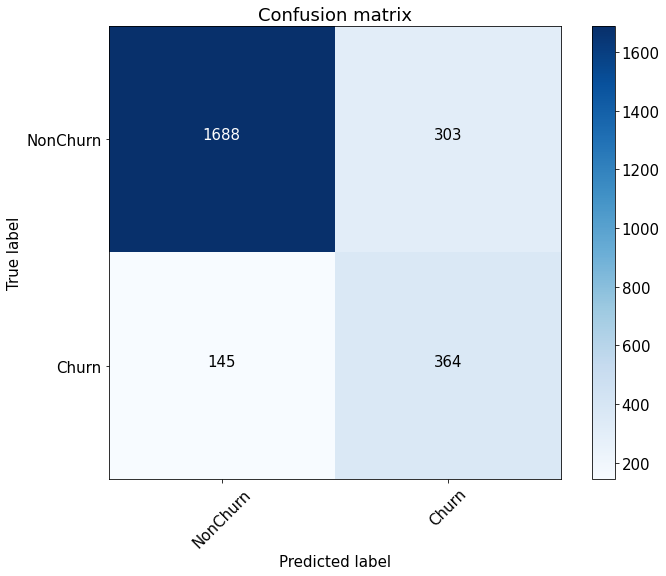

In [22]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_rf>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

потратим (303+364)*1 = 667

получим 364*2 = 728

728-667=61

Ну, в принципе, доход есть, но не очень большой. Лучше, чем сидеть сложа руки, я думаю)

##### Для catboost:

Confusion matrix, without normalization
[[1737  254]
 [ 152  357]]


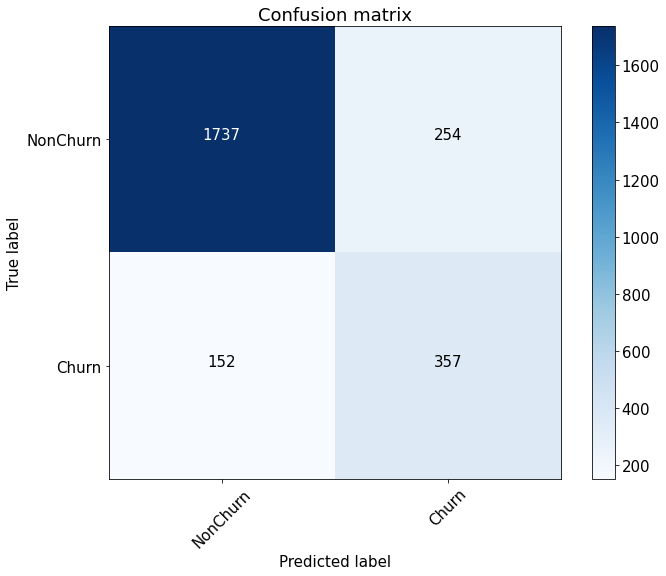

In [23]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_cb>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

потратим (254+357)*1 = 611

получим 357*2 = 714

714-611=103

C катбустом-то прибыль в полтора раза больше, довольно внушительно, принимая во внимание, что precision +0.007, a recall +0.004. Теперь ясно зачем нужно уметь выжимать эти тысячные доли из модели :) 